<a href="https://colab.research.google.com/github/angelfm8/fcc_book_recommendation/blob/main/fcc_book_recommendation_knn(ag).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'


--2024-06-11 20:01:56--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  89.8MB/s    in 0.3s    

2024-06-11 20:01:57 (89.8 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [3]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

# Clean data.
Para la limpieza de los datos lo primero que hacemos es comprobar que no haya libros guardados con diferentes identificadores.

Para ello lo primero que hacemos es crear una nueva columna en 'df_books' en la que incluya titulo y author en la misma cadena.

In [4]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [5]:
df_books['titulo'] = df_books.title + ', ' + df_books.author
df_books.head()

,isbn,title,author,titulo
0,0195153448,Classical Mythology,Mark P. O. Morford,"Classical Mythology, Mark P. O. Morford"
1,0002005018,Clara Callan,Richard Bruce Wright,"Clara Callan, Richard Bruce Wright"
2,0060973129,Decision in Normandy,Carlo D'Este,"Decision in Normandy, Carlo D'Este"
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,Flu: The Story of the Great Influenza Pandemic...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,"The Mummies of Urumchi, E. J. W. Barber"


---
Tras esto creamos un nuevo dataframe en el cual eliminaremos aquellos libros que se encuentren duplicados con distintos isbn.

In [6]:
df_books_rm = df_books.drop_duplicates('titulo')
df_books_rm.head()

,isbn,title,author,titulo
0,0195153448,Classical Mythology,Mark P. O. Morford,"Classical Mythology, Mark P. O. Morford"
1,0002005018,Clara Callan,Richard Bruce Wright,"Clara Callan, Richard Bruce Wright"
2,0060973129,Decision in Normandy,Carlo D'Este,"Decision in Normandy, Carlo D'Este"
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,Flu: The Story of the Great Influenza Pandemic...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,"The Mummies of Urumchi, E. J. W. Barber"


In [7]:
len(df_books), len(df_books), len(df_books)-len(df_books_rm)

(271379, 271379, 20176)

---
Despues modificamos los isbn en `df_ratings` cambiando aquellos que se referian al mismo libro por el isbn final que aparece en `df_books_rm`

In [8]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [9]:
clean_ratings = df_ratings.drop_duplicates(['isbn', 'user'])
df_ratings.shape, clean_ratings.shape

((1149780, 3), (1149780, 3))

In [10]:
clean_ratings['isbn'] = clean_ratings['isbn'].map(df_books.set_index('isbn').to_dict()['titulo'])
clean_ratings['isbn'] = clean_ratings['isbn'].map(df_books_rm.set_index('titulo').to_dict()['isbn'])
clean_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446605239,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [11]:
[[len(df_ratings['isbn'].unique()), len(clean_ratings['isbn'].unique())],[len(df_ratings['isbn'].unique())/len(df_ratings), len(clean_ratings['isbn'].unique())/len(clean_ratings)], [len(df_ratings), len(clean_ratings)]]

[[340556, 250104],
 [0.29619231505157506, 0.21752335229348224],
 [1149780, 1149780]]

In [12]:
clean_ratings = df_ratings.drop_duplicates(['isbn', 'user'])
clean_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [13]:
df_ratings.shape, clean_ratings.shape

((1149780, 3), (1149780, 3))

---
Mediante esta limpieza hemos reducido el número de códigos.

Para una limpieza mas exhaustiva deberiamos comprobar también que no hubiese libros cuyo titulo solo difiere en mayusculas, minusculas o errores ortograficos para reducir aun más el numero de ISBN distintos.

---



Como extra se añaden ciertos gráficos con relación a los datos

# REVIEWS AND USER BEHAVIOR GRAPHS AND VISUALS

---
## BASIC STATS

In [14]:
grouped_by_user = clean_ratings.groupby(['user'])
user_ratings = grouped_by_user['rating'].agg(['sum', 'count', 'mean']).reset_index()

user_count = len(grouped_by_user['user'])
review_count = len(clean_ratings)
most_active_list = user_ratings.sort_values(by='count')
most_active_user = most_active_list.iloc[-1];
print('There is over {:,} reviews in the database written by {:,} users'.format(review_count, user_count))
print('The most active user (ID: #{}) has written {:,} reviews\n'.format(most_active_user.name, int(most_active_user['count'])))

There is over 1,149,780 reviews in the database written by 105,283 users
The most active user (ID: #4213) has written 13,602 reviews



---
## WHERE DO MOST OF OUR REVIEWS COME FROM?

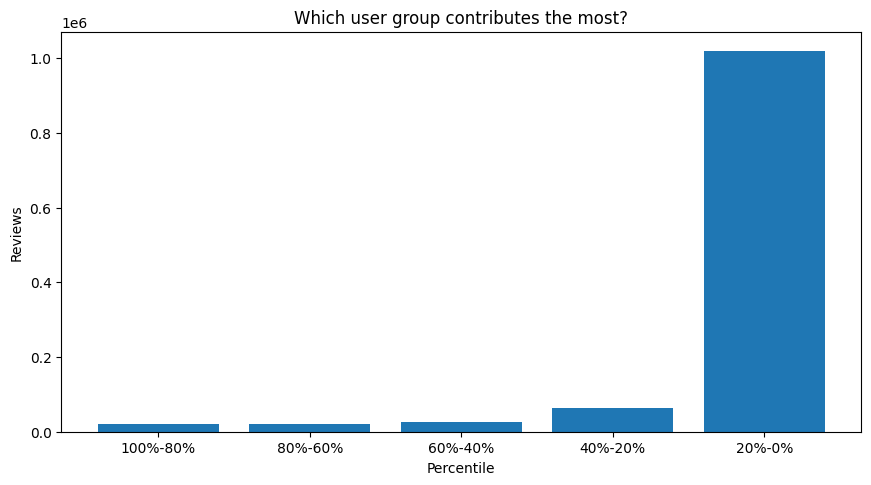


The top 20% of users contributed to 88.73% of reviews

Insight: Almost all our reviews come from 'superusers' who have a lot of opinions to share



In [16]:
# Graph
SLICE_NUMBERS = 5
step_size = int(user_count/SLICE_NUMBERS)
percentile = int(100 / SLICE_NUMBERS);
labels_percentile = ['{}%-{}%'.format(100-(n*percentile), 100-((n+1)*percentile)) for n in range(SLICE_NUMBERS)]
count_per_percentile = []
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
reviews_distribution = most_active_list['count'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
    ).sum()
most_active_list['distribution'] = reviews_distribution

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
ax.bar(labels_percentile, reviews_distribution.tolist())
plt.title('Which user group contributes the most?')
plt.xlabel('Percentile')
plt.ylabel('Reviews')
plt.show()

# Hard numbers
top_reviewers_count = most_active_list.iloc[-step_size:]['count'].sum()
print('\nThe top {}% of users contributed to {}% of reviews'.format(percentile, round(top_reviewers_count/review_count*100,2)))

print("\nInsight: Almost all our reviews come from 'superusers' who have a lot of opinions to share\n")

---
## HOW MANY REVIEWS DO USERS USUALLY LEAVE?

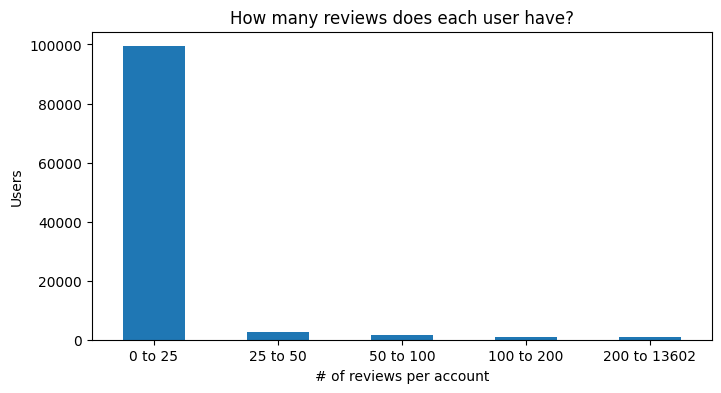


There are 92,186 users (87.56%) who have written less than 10 reviews

Insight: Most users will write less than 10 reviews


In [21]:
# Graph
binned = pd.cut(user_ratings['count'], bins=[0, 25, 50, 100, 200, user_ratings['count'].max()])
ax = binned.value_counts(sort=False).plot.bar(rot=0, figsize=(8,4))
ax.set_xticklabels(["{} to {}".format(c.left, c.right) for c in binned.cat.categories])
plt.title('How many reviews does each user have?')
plt.ylabel("Users")
plt.xlabel("# of reviews per account")
plt.show()

# Hard numbers
LOW_COUNT_THRESOLD = 10
inactive_users = user_ratings[user_ratings['count'] < LOW_COUNT_THRESOLD]
inactive_count = len(inactive_users)
inactive_percentage = round(inactive_count/user_count*100,2)
print('\nThere are {:,} users ({}%) who have written less than {} reviews'.format(inactive_count, inactive_percentage, LOW_COUNT_THRESOLD));

print("\nInsight: Most users will write less than 10 reviews")

---
## WHAT IS THE RELATIONSHIP B/T ENGAGEMENT RATE AND AVERAGE REVIEW SCORES?

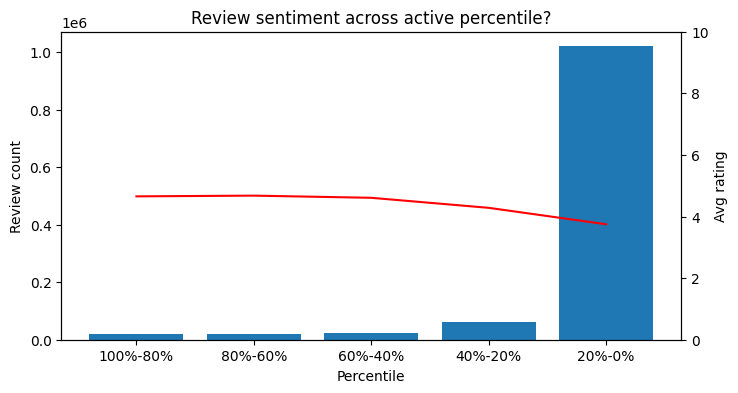


The average review is 2.87

There is 823,436 (71.62%) reviews that are between 0 and 6

Insight: There is no correlation with sustained engagement and rating



In [29]:
# Graph
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
score_distribution = most_active_list['mean'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
).mean()
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(labels_percentile, reviews_distribution.tolist())
ax2 = ax.twinx()
ax2.plot(labels_percentile, score_distribution.tolist(), color = 'red')
ax.set_xlabel('Percentile')
ax.set_ylabel('Review count')
ax2.set_ylabel('Avg rating')
ax2.set_ylim(0,10)

plt.title('Review sentiment across active percentile?')
plt.xlabel('Review count')
plt.show()

# Hard number
score_range = (0, 6)
reviews_within_range = clean_ratings.query('{} <= rating <= {}'.format(score_range[0], score_range[1]))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg = df_ratings['rating'].mean()
print('\nThe average review is {0:.2f}'.format(avg))
print('\nThere is {:,} ({}%) reviews that are between {} and {}'.format(within_range_count, within_range_percent, score_range[0], score_range[1]))

print('\nInsight: There is no correlation with sustained engagement and rating\n')


---
## WHAT REVIEW SCORES ARE MOST OFTEN POSTED ON THE SITE?


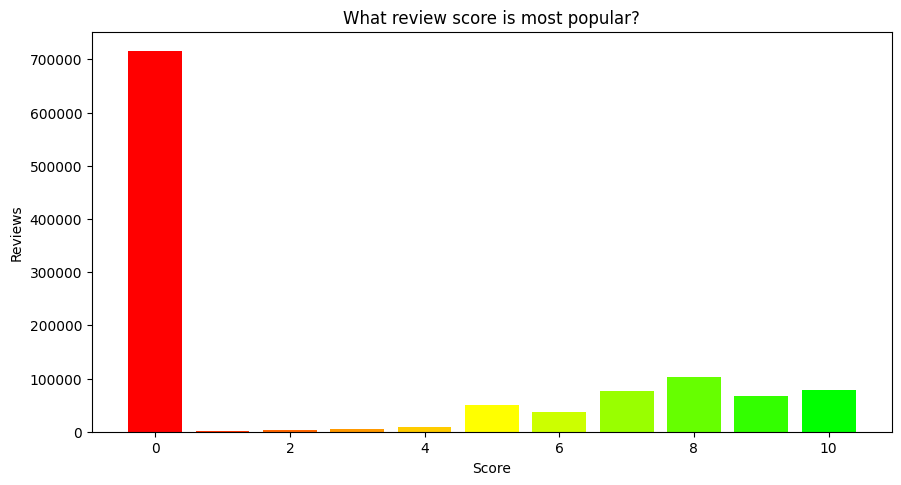


The global review average is 2.87

There are 38,881 users (36.93%) who's average review is lower than 3

Insight: Either our users hate our selection or they don't write about the books they loved.



In [28]:
# Graph
grouped_by_score = clean_ratings.groupby(['rating']).count()
scores = clean_ratings['rating'].unique().tolist()
scores.sort()
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
colors = ['#FF0000','#FF3300', '#ff6600', '#ff9900', '#FFCC00','#FFFF00', '#ccff00', '#99ff00', '#66ff00', '#33ff00', '#00FF00']
ax.bar(scores, grouped_by_score['user'], color=colors)
plt.title('What review score is most popular?')
plt.xlabel('Score')
plt.ylabel('Reviews')
plt.show()

# Hard number
low_score_threshold = 2
reviews_within_range = clean_ratings.query('rating < {}'.format(low_score_threshold))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg = clean_ratings['rating'].mean()
print('\nThe global review average is {0:.2f}'.format(avg))
#print('\nThere is {:,} ({}%) reviews lower than {}'.format(within_range_count, within_range_percent, low_score_threshold))

# How many users are chronical haters ?
HATER_THRESHOLD = 3
haters = user_ratings[user_ratings['mean'] < HATER_THRESHOLD]
haters_count = len(haters)
hater_percentage = round(haters_count/user_count*100,2)
print('\nThere are {:,} users ({}%) who\'s average review is lower than {}'.format(haters_count, hater_percentage, HATER_THRESHOLD));

print('\nInsight: Either our users hate our selection or they don\'t write about the books they loved.\n')

---
### BOOKS GRAPHS AND VISUALS

## BASIC STATS

In [67]:
#Cambiar los ratings por el titulo.
books_with_ratings = clean_ratings.copy()
books_with_ratings['title'] = rating_con_titulo['isbn'].map(df_books.set_index('isbn').to_dict()['title'])
books_with_ratings['author'] = rating_con_titulo['isbn'].map(df_books.set_index('isbn').to_dict()['author'])


grouped_by_isbn = books_with_ratings.groupby(['title'])['rating'].agg(['sum', 'count', 'mean']).reset_index()

books_count = len(df_books_rm)
print('There are {:,} books registered in the database\n'.format(books_count))

# Top 10 most rated books
books_sorted_by_count = grouped_by_isbn.sort_values(by='count', ascending = False)
print('Top 10 most rated books')
books_sorted_by_count.head(10)



There are 251,203 books registered in the database

Top 10 most rated books


,title,sum,count,mean
234964,Wild Animus,2551.0,2502,1.019584
196337,The Lovely Bones: A Novel,5787.0,1295,4.468726
183582,The Da Vinci Code,4169.0,898,4.642539
5303,A Painted House,2708.0,838,3.231503
199248,The Nanny Diaries: A Novel,2923.0,828,3.530193
27923,Bridget Jones's Diary,2875.0,815,3.527607
206513,The Secret Life of Bees,3442.0,774,4.447029
52985,Divine Secrets of the Ya-Ya Sisterhood: A Novel,2544.0,740,3.437838
204398,The Red Tent (Bestselling Backlist),3134.0,723,4.334716
14392,Angels &amp; Demons,2485.0,670,3.708955


## WHAT ARE THE BOOKS THAT DRAW THE MOST HEAT & LOVE?

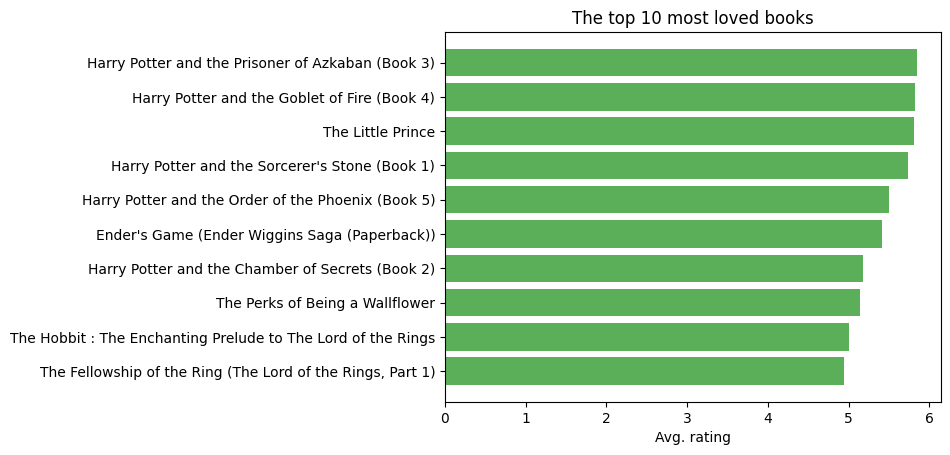

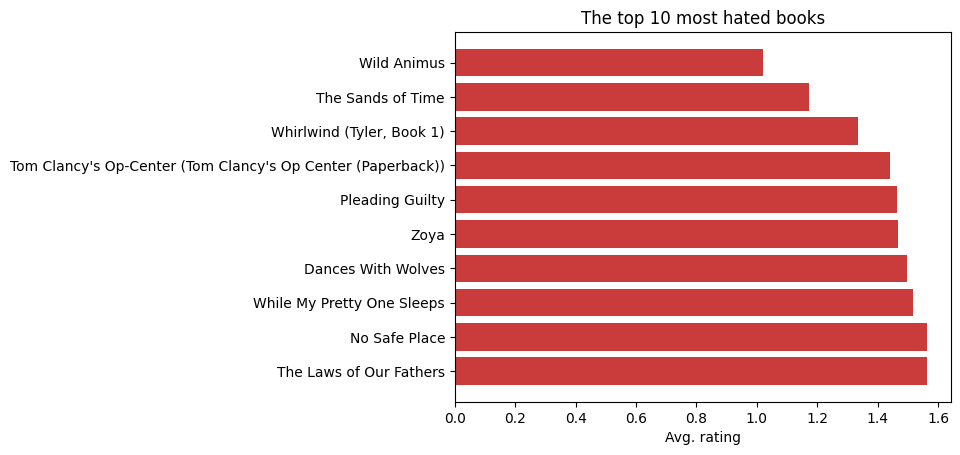


 Insight: Our most popular books is "Harry Potter and the Prisoner of Azkaban (Book 3)" and our most disliked one is "Wild Animus"



In [68]:
books_sorted_by_rating = grouped_by_isbn.query('count >= 100').sort_values(by='mean')
most_loved_books = books_sorted_by_rating.iloc[-10:]
most_hated_books = books_sorted_by_rating.iloc[:10].iloc[::-1]
plt.barh(most_loved_books['title'], most_loved_books['mean'], color='#5baf59')
plt.xlabel("Avg. rating")
plt.title("The top 10 most loved books")
plt.show()
print('\n')
plt.barh(most_hated_books['title'], most_hated_books['mean'], color='#ca3c3b')
plt.xlabel("Avg. rating")
plt.title("The top 10 most hated books")
plt.show()
print('\n Insight: Our most popular books is "{}" and our most disliked one is "{}"\n'.format(most_loved_books.values[-1][0], most_hated_books.values[-1][0]))

## WHO ARE THE AUTHORS THAT DRAW THE MOST HEAT & LOVE?

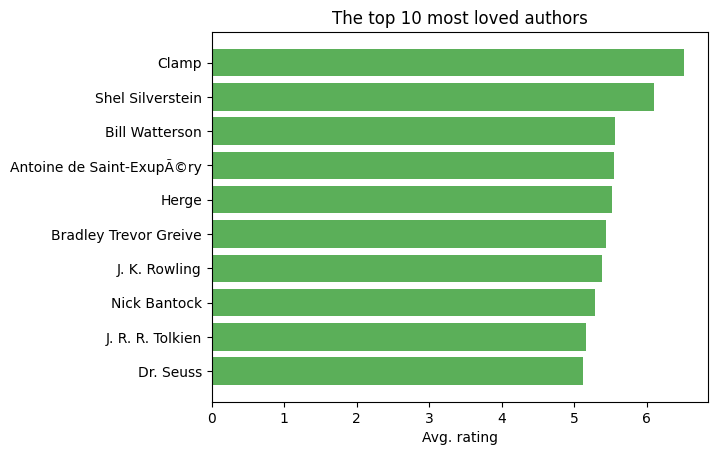

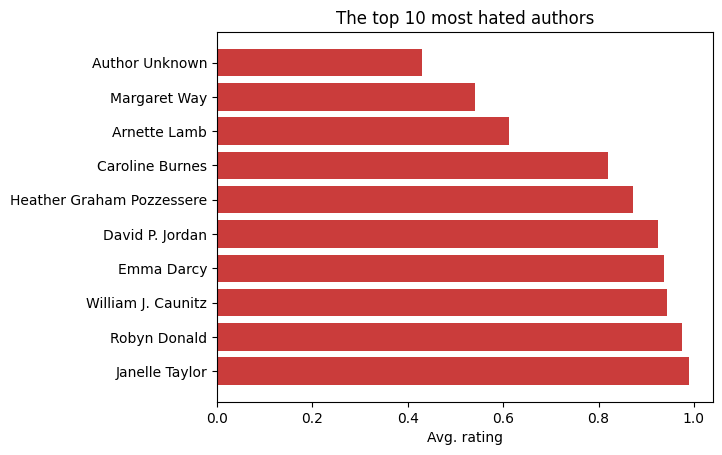


 Insight: Our most popular author is "Clamp" and our most disliked one is "Author Unknown"



In [70]:
grouped_by_author = books_with_ratings.groupby(['author'])['rating'].agg(['count', 'mean']).reset_index()
authors_sorted_by_rating = grouped_by_author.query('count >= 100').sort_values(by='mean')
most_loved_authors = authors_sorted_by_rating.iloc[-10:]
most_hated_authors = authors_sorted_by_rating.iloc[:10].iloc[::-1]

plt.barh(most_loved_authors['author'], most_loved_authors['mean'], color='#5baf59')
plt.xlabel("Avg. rating")
plt.title("The top 10 most loved authors")
plt.show()
print('\n')
plt.barh(most_hated_authors['author'], most_hated_authors['mean'], color='#ca3c3b')
plt.xlabel("Avg. rating")
plt.title("The top 10 most hated authors")
plt.show()

print('\n Insight: Our most popular author is "{}" and our most disliked one is "{}"\n'.format(most_loved_authors.values[-1][0], most_hated_authors.values[-1][0]))


---
## How are reviews distributed?

In [101]:
bin_counts

count
(0, 25]        235499
(25, 50]         3210
(50, 100]        1477
(100, 2502]       904
Name: count, dtype: int64

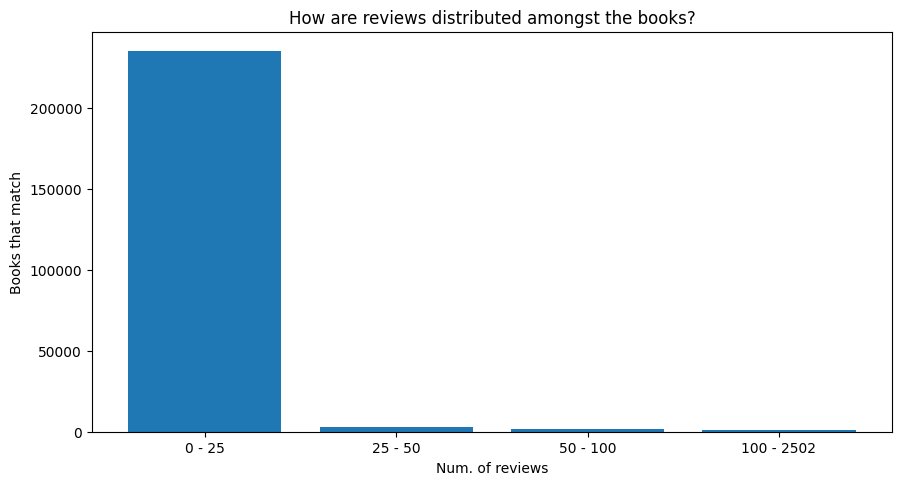


Insight: Over 0.36% of our books have more than than 25 reviews.



In [103]:
bin_books_percentile = pd.cut(grouped_by_isbn['count'], bins=[0, 25, 50, 100, grouped_by_isbn['count'].max()])
bin_counts = bin_books_percentile.value_counts().sort_index()
bin_labels = ['{} - {}'.format(c.left, c.right) for c in bin_books_percentile.values.categories]
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
ax.bar(bin_labels, bin_counts)
plt.ylabel('Books that match')
plt.xlabel('Num. of reviews')
plt.title('How are reviews distributed amongst the books?')
plt.show()

# Hard numbers
last_bin_percentage = round(bin_counts[grouped_by_isbn['count'].max()]/books_count*100, 2)
bin_right_edge = bin_books_percentile.values[-1].right;
print('\nInsight: Over {}% of our books have more than than {} reviews.\n'.format(last_bin_percentage, bin_right_edge))

---
#Datos relevantes

A raiz de los resultados expresados en las gráficas se realiza una limpieza de usuarios y libros con pocas valoraciones


---


In [104]:
userCounts = clean_ratings['user'].value_counts()
isbnCounts = clean_ratings['isbn'].value_counts()
#remove all users with less than 200 reviews.
clean_ratings = clean_ratings[~clean_ratings['user'].isin(userCounts[userCounts < 200].index)]
#remove all books with less than 100 ratings
clean_ratings = clean_ratings[~clean_ratings['isbn'].isin(isbnCounts[isbnCounts < 100].index)]
df_books_rm = df_books_rm[~df_books_rm['isbn'].isin(isbnCounts[isbnCounts < 100].index)]
clean_ratings.shape

(49781, 3)

Con la limpieza de datos realizamos de nuevo la parte visual.

---
## BASIC STATS

In [105]:
grouped_by_user = clean_ratings.groupby(['user'])
user_ratings = grouped_by_user['rating'].agg(['sum', 'count', 'mean']).reset_index()

user_count = len(grouped_by_user['user'])
review_count = len(clean_ratings)
most_active_list = user_ratings.sort_values(by='count')
most_active_user = most_active_list.iloc[-1];
print('There is over {:,} reviews in the database written by {:,} users'.format(review_count, user_count))
print('The most active user (ID: #{}) has written {:,} reviews\n'.format(most_active_user.name, int(most_active_user['count'])))

There is over 49,781 reviews in the database written by 888 users
The most active user (ID: #25) has written 660 reviews



---
## WHERE DO MOST OF OUR REVIEWS COME FROM?

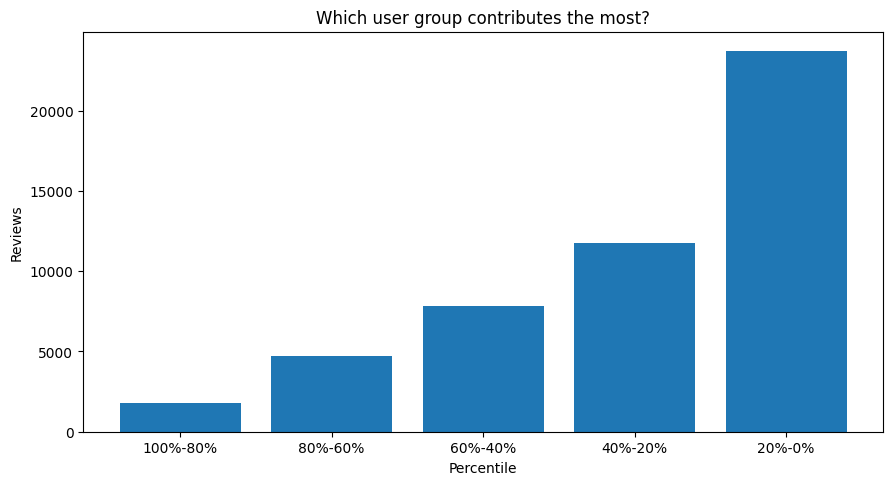


The top 20% of users contributed to 47.51% of reviews

Insight: Almost all our reviews come from 'superusers' who have a lot of opinions to share



In [106]:
# Graph
SLICE_NUMBERS = 5
step_size = int(user_count/SLICE_NUMBERS)
percentile = int(100 / SLICE_NUMBERS);
labels_percentile = ['{}%-{}%'.format(100-(n*percentile), 100-((n+1)*percentile)) for n in range(SLICE_NUMBERS)]
count_per_percentile = []
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
reviews_distribution = most_active_list['count'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
    ).sum()
most_active_list['distribution'] = reviews_distribution

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
ax.bar(labels_percentile, reviews_distribution.tolist())
plt.title('Which user group contributes the most?')
plt.xlabel('Percentile')
plt.ylabel('Reviews')
plt.show()

# Hard numbers
top_reviewers_count = most_active_list.iloc[-step_size:]['count'].sum()
print('\nThe top {}% of users contributed to {}% of reviews'.format(percentile, round(top_reviewers_count/review_count*100,2)))

print("\nInsight: Almost all our reviews come from 'superusers' who have a lot of opinions to share\n")

---
## HOW MANY REVIEWS DO USERS USUALLY LEAVE?

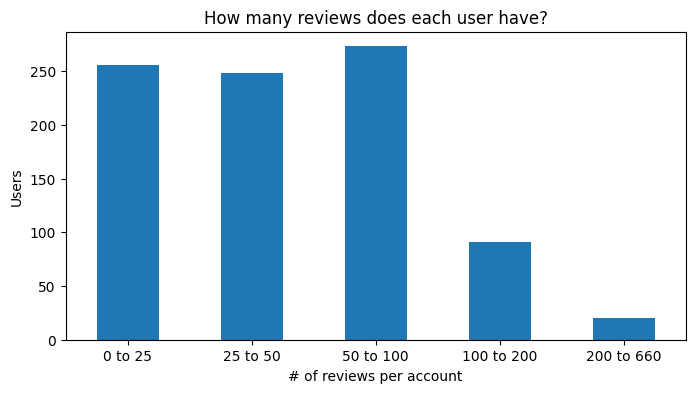


There are 80 users (9.01%) who have written less than 10 reviews

Insight: Most users will write less than 10 reviews


In [107]:
# Graph
binned = pd.cut(user_ratings['count'], bins=[0, 25, 50, 100, 200, user_ratings['count'].max()])
ax = binned.value_counts(sort=False).plot.bar(rot=0, figsize=(8,4))
ax.set_xticklabels(["{} to {}".format(c.left, c.right) for c in binned.cat.categories])
plt.title('How many reviews does each user have?')
plt.ylabel("Users")
plt.xlabel("# of reviews per account")
plt.show()

# Hard numbers
LOW_COUNT_THRESOLD = 10
inactive_users = user_ratings[user_ratings['count'] < LOW_COUNT_THRESOLD]
inactive_count = len(inactive_users)
inactive_percentage = round(inactive_count/user_count*100,2)
print('\nThere are {:,} users ({}%) who have written less than {} reviews'.format(inactive_count, inactive_percentage, LOW_COUNT_THRESOLD));

print("\nInsight: Most users will write less than 10 reviews")

---
## WHAT IS THE RELATIONSHIP B/T ENGAGEMENT RATE AND AVERAGE REVIEW SCORES?

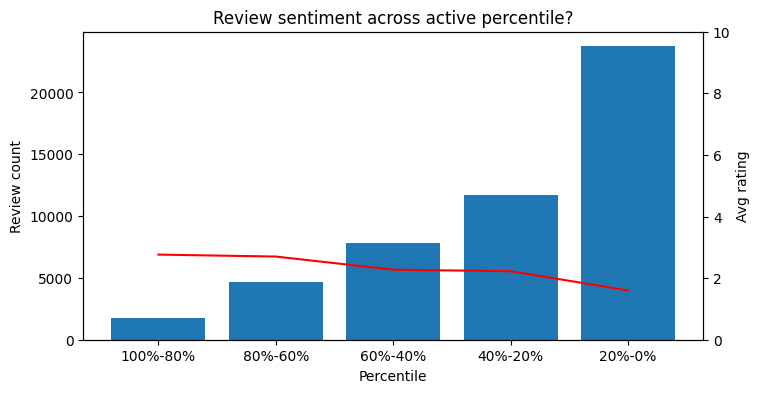


The average review is 2.87

There is 39,357 (79.06%) reviews that are between 0 and 6

Insight: Now we can see some correlation with sustained engagement and rating.
 More active users usually give more low ratings


In [110]:
# Graph
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
score_distribution = most_active_list['mean'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
).mean()
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(labels_percentile, reviews_distribution.tolist())
ax2 = ax.twinx()
ax2.plot(labels_percentile, score_distribution.tolist(), color = 'red')
ax.set_xlabel('Percentile')
ax.set_ylabel('Review count')
ax2.set_ylabel('Avg rating')
ax2.set_ylim(0,10)

plt.title('Review sentiment across active percentile?')
plt.xlabel('Review count')
plt.show()

# Hard number
score_range = (0, 6)
reviews_within_range = clean_ratings.query('{} <= rating <= {}'.format(score_range[0], score_range[1]))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg = df_ratings['rating'].mean()
print('\nThe average review is {0:.2f}'.format(avg))
print('\nThere is {:,} ({}%) reviews that are between {} and {}'.format(within_range_count, within_range_percent, score_range[0], score_range[1]))

print('\nInsight: Now we can see some correlation with sustained engagement and rating.\n More active users usually give more low ratings')


---
## WHAT REVIEW SCORES ARE MOST OFTEN POSTED ON THE SITE?


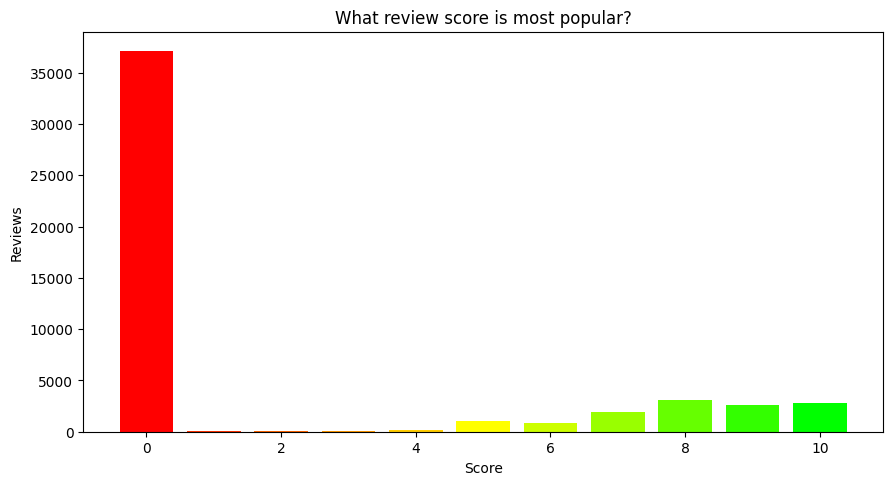


The global review average is 2.02

There are 649 users (73.09%) who's average review is lower than 3

Insight: Either our users hate our selection or they don't write about the books they loved.



In [111]:
# Graph
grouped_by_score = clean_ratings.groupby(['rating']).count()
scores = clean_ratings['rating'].unique().tolist()
scores.sort()
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
colors = ['#FF0000','#FF3300', '#ff6600', '#ff9900', '#FFCC00','#FFFF00', '#ccff00', '#99ff00', '#66ff00', '#33ff00', '#00FF00']
ax.bar(scores, grouped_by_score['user'], color=colors)
plt.title('What review score is most popular?')
plt.xlabel('Score')
plt.ylabel('Reviews')
plt.show()

# Hard number
low_score_threshold = 2
reviews_within_range = clean_ratings.query('rating < {}'.format(low_score_threshold))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg = clean_ratings['rating'].mean()
print('\nThe global review average is {0:.2f}'.format(avg))
#print('\nThere is {:,} ({}%) reviews lower than {}'.format(within_range_count, within_range_percent, low_score_threshold))

# How many users are chronical haters ?
HATER_THRESHOLD = 3
haters = user_ratings[user_ratings['mean'] < HATER_THRESHOLD]
haters_count = len(haters)
hater_percentage = round(haters_count/user_count*100,2)
print('\nThere are {:,} users ({}%) who\'s average review is lower than {}'.format(haters_count, hater_percentage, HATER_THRESHOLD));

print('\nInsight: Either our users hate our selection or they don\'t write about the books they loved.\n')

---
### BOOKS GRAPHS AND VISUALS

## BASIC STATS

In [112]:
#Cambiar los ratings por el titulo.
books_with_ratings = clean_ratings.copy()
books_with_ratings['title'] = rating_con_titulo['isbn'].map(df_books.set_index('isbn').to_dict()['title'])
books_with_ratings['author'] = rating_con_titulo['isbn'].map(df_books.set_index('isbn').to_dict()['author'])


grouped_by_isbn = books_with_ratings.groupby(['title'])['rating'].agg(['sum', 'count', 'mean']).reset_index()

books_count = len(df_books_rm)
print('There are {:,} books registered in the database\n'.format(books_count))

# Top 10 most rated books
books_sorted_by_count = grouped_by_isbn.sort_values(by='count', ascending = False)
print('Top 10 most rated books')
books_sorted_by_count.head(10)



There are 1,718 books registered in the database

Top 10 most rated books


,title,sum,count,mean
665,Wild Animus,159.0,365,0.435616
539,The Lovely Bones: A Novel,870.0,272,3.198529
92,Bridget Jones's Diary,692.0,255,2.713726
544,The Nanny Diaries: A Novel,457.0,230,1.986956
18,A Painted House,443.0,226,1.960177
147,Divine Secrets of the Ya-Ya Sisterhood: A Novel,422.0,221,1.909502
551,The Pelican Brief,411.0,218,1.885321
476,The Da Vinci Code,688.0,217,3.170507
548,The Notebook,396.0,207,1.913043
493,The Firm,432.0,204,2.117647


## WHAT ARE THE BOOKS THAT DRAW THE MOST HEAT & LOVE?

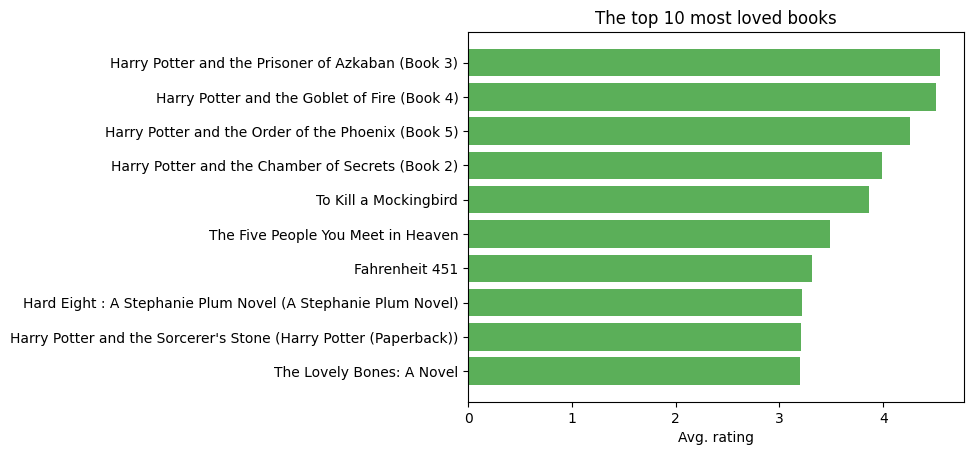

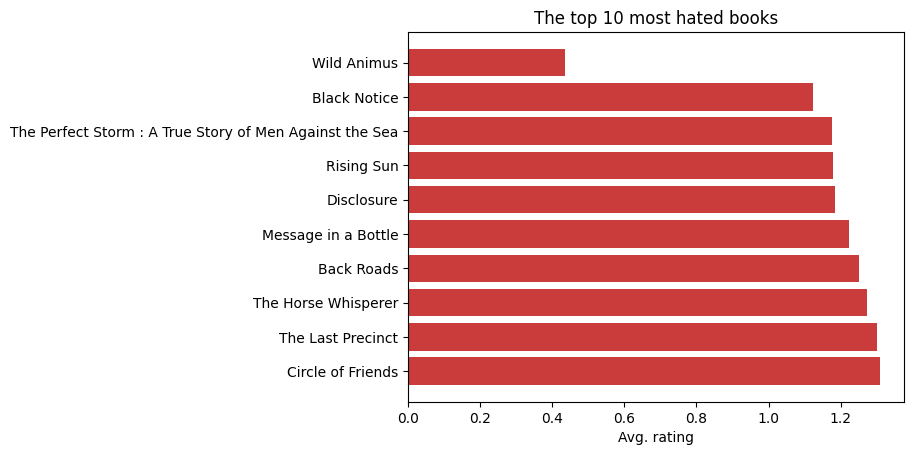


 Insight: Our most popular books is "Harry Potter and the Prisoner of Azkaban (Book 3)" and our most disliked one is "Wild Animus"



In [113]:
books_sorted_by_rating = grouped_by_isbn.query('count >= 100').sort_values(by='mean')
most_loved_books = books_sorted_by_rating.iloc[-10:]
most_hated_books = books_sorted_by_rating.iloc[:10].iloc[::-1]
plt.barh(most_loved_books['title'], most_loved_books['mean'], color='#5baf59')
plt.xlabel("Avg. rating")
plt.title("The top 10 most loved books")
plt.show()
print('\n')
plt.barh(most_hated_books['title'], most_hated_books['mean'], color='#ca3c3b')
plt.xlabel("Avg. rating")
plt.title("The top 10 most hated books")
plt.show()
print('\n Insight: Our most popular books is "{}" and our most disliked one is "{}"\n'.format(most_loved_books.values[-1][0], most_hated_books.values[-1][0]))

## WHO ARE THE AUTHORS THAT DRAW THE MOST HEAT & LOVE?

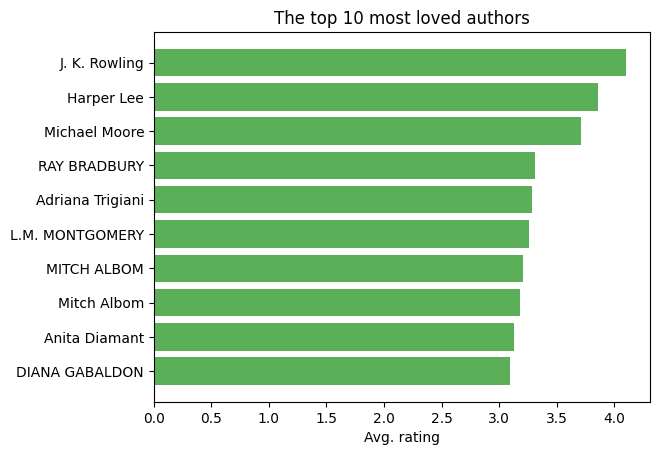

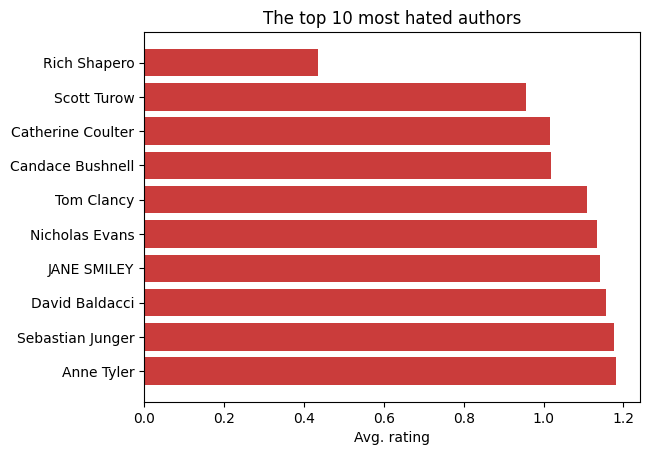


 Insight: Our most popular author is "J. K. Rowling" and our most disliked one is "Rich Shapero"



In [114]:
grouped_by_author = books_with_ratings.groupby(['author'])['rating'].agg(['count', 'mean']).reset_index()
authors_sorted_by_rating = grouped_by_author.query('count >= 100').sort_values(by='mean')
most_loved_authors = authors_sorted_by_rating.iloc[-10:]
most_hated_authors = authors_sorted_by_rating.iloc[:10].iloc[::-1]

plt.barh(most_loved_authors['author'], most_loved_authors['mean'], color='#5baf59')
plt.xlabel("Avg. rating")
plt.title("The top 10 most loved authors")
plt.show()
print('\n')
plt.barh(most_hated_authors['author'], most_hated_authors['mean'], color='#ca3c3b')
plt.xlabel("Avg. rating")
plt.title("The top 10 most hated authors")
plt.show()

print('\n Insight: Our most popular author is "{}" and our most disliked one is "{}"\n'.format(most_loved_authors.values[-1][0], most_hated_authors.values[-1][0]))


---
## How are reviews distributed?

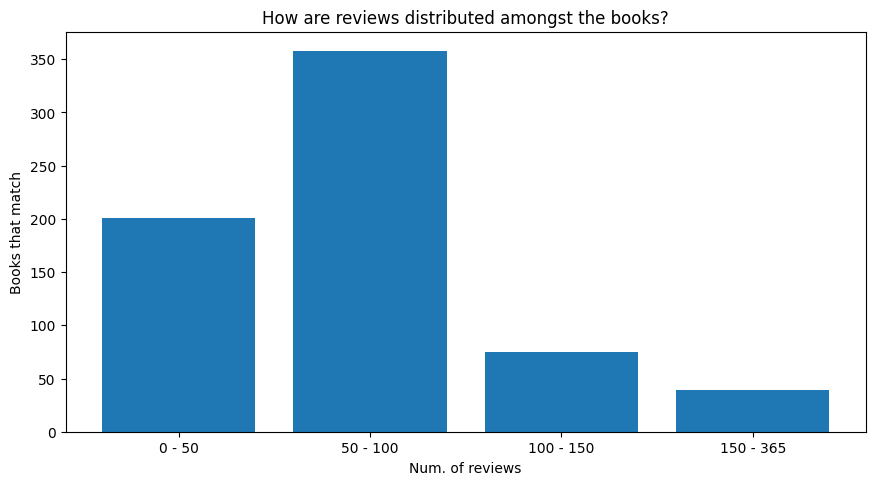


Insight: Over 2.27% of our books have more than than 150 reviews.



In [126]:
bin_right_edge = 150;
bin_books_percentile = pd.cut(grouped_by_isbn['count'], bins=[0, 50, 100, 150, grouped_by_isbn['count'].max()])
bin_counts = bin_books_percentile.value_counts().sort_index()
bin_labels = ['{} - {}'.format(c.left, c.right) for c in bin_books_percentile.values.categories]
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
ax.bar(bin_labels, bin_counts)
plt.ylabel('Books that match')
plt.xlabel('Num. of reviews')
plt.title('How are reviews distributed amongst the books?')
plt.show()

# Hard numbers
last_bin_percentage = round(bin_counts[grouped_by_isbn['count'].max()]/books_count*100, 2)
print('\nInsight: Over {}% of our books have more than than {} reviews.\n'.format(last_bin_percentage, bin_right_edge))

------
#Solución del problema de FreeCodeCamp:

A continuación pasamos a realizar una limpieza para eliminar usuarios y libros de los cuales haya pocas calificaciones.

Para todo lo que queda utilizaremos los dataframe:
`df_ratings` y `df_books` para con ello poder superar el reto de FreeCodeCamp

In [127]:
userCounts = df_ratings['user'].value_counts()
isbnCounts = df_ratings['isbn'].value_counts()
#remove all users with less than 200 reviews
df_ratings = df_ratings[~df_ratings['user'].isin(userCounts[userCounts < 200].index)]
#remove all books with less than 100 ratings
df_ratings = df_ratings[~df_ratings['isbn'].isin(isbnCounts[isbnCounts < 100].index)]

df_ratings.shape

(49781, 3)

Una vez realizada la limpieza comenzamos a crear el algoritmo.
Para ello es neceario crear una tabla que combine los titulos de los libros con los usuarios para realizar el algoritmo de recomendacion.





In [128]:
df = pd.merge(right=df_ratings, left = df_books, on="isbn")

df = df.drop_duplicates(["title", "user"])

piv = df.pivot(index='title', columns='user', values='rating').fillna(0)

piv

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Without Remorse,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of Wonders,0.0,0.0,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
from sklearn.neighbors import NearestNeighbors
model_knn=NearestNeighbors(metric='cosine',algorithm='brute')
model_knn.fit(piv.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [130]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
  x=piv.loc[book].array.reshape(1, -1)
  distances,indices=model_knn.kneighbors(x,n_neighbors=6)
  R_books=[]
  for distance,indice in zip(distances[0],indices[0]):
    if distance!=0:
      R_book=piv.index[indice]
      R_books.append([R_book,distance])
  recommended_books=[book,R_books[::-1]]
  return recommended_books

In [131]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
